# Covariance Matrix Adaptation(CMA) - ES
Given a population, we select only the top $f$ fraction of members. The rest are decimated.

Then, to get the remaining population for the next generation, we calculate the mean $\mu_{g+1}$ and covariance matrix $\Sigma_{g+1}$.

The trick here, is that $\Sigma_{g+1}$ is calculated using the $\mu_g$ of the previous generation.

In code:
```python
def cma_es(population):
    fitness = list(map(evaluator, population))
    fitness_ids = argsort(fitness)
    
    surviving_ids = fitness_ids[-int(surviving_fraction * len(population)):]
    survivors = population[surviving_ids]
    
    self._cov = cov(self._survivors, self._mean)
    self._mean = self._survivors.mean()
    
    new_population = normal(self._mean, self._cov)
    return new_population
```

# Setup

## Imports

In [1]:
import gym

Torch Modules

In [2]:
import torch

from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

In [3]:
from functools import partial
from tqdm import tqdm_notebook as tqdm

from concurrent.futures import ProcessPoolExecutor

In [4]:
from utils.environment import add_energy, make_specs, run_env
from utils.model import get_params, set_params, get_action
from utils.genetic import ES

## Define Useful Features

In [5]:
jtplot_style()

## Load Environment

In [6]:
env = gym.make('Acrobot-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
make_specs(env)
n_obs = env.spec.n_obs
n_act = env.spec.n_act

In [8]:
add_energy(env)

# Create Model

In [9]:
get_model = lambda: nn.Linear(n_obs, n_act)

In [10]:
model = get_model()

# Create CMA-ES

In [11]:
class CmaES(ES):
    def __init__(self, evaluator, population_size, mean, surviving_fraction=0.25):
        super().__init__(population_size)
        self._evaluator = evaluator
        self._surviving_size = max(2, int(surviving_fraction * population_size))
            
        self._mean = mean
        self._population = [mean + torch.randn(len(mean)) 
                            for _ in range(population_size)]
        self._history.append((0, evaluator(mean)))
        
    def _strategy(self, num_workers):
        with ProcessPoolExecutor(num_workers) as executor: 
            fitnesses = list(executor.map(self._evaluator, self._population))
            
        fitness_ids = np.argsort(fitnesses)
        surviving_ids = fitness_ids[-self._surviving_size:]
        survivors = torch.stack([self._population[i] for i in surviving_ids])
        
        def cov(x, m):
            p = x - m
            return (p.unsqueeze(-1) * p.unsqueeze(1)).mean(0)
        
        self._cov = cov(survivors, self._mean)
        self._mean = survivors.mean(0)
        
        def _multivariate(mu, sigma):
            l = torch.from_numpy(np.linalg.cholesky(sigma.numpy()))
            return list(torch.mm(torch.randn(self._population_size - self._surviving_size,
                                             len(mu)), l))
        
        new_population = _multivariate(self._mean, self._cov) + list(survivors)
        
        fitness = fitnesses[surviving_ids[-1]]
        self._solution = survivors[-1]
        
        return new_population, fitness
    
    def solution(self):
        return self._solution

In [12]:
def evaluator(params, gamma=0, episodes=1):
    model = get_model()
    set_params(model, params)
    rewards, energies = run_env(env, lambda x: get_action(model, x), episodes)
    return rewards - gamma * energies

In [13]:
solver = CmaES(partial(evaluator, gamma=0.0, episodes=1), 100, 
                  torch.zeros(len(get_params(model))))

In [14]:
solver(4)

HBox(children=(IntProgress(value=0, max=4), HTML(value='')))

-76.00


In [15]:
solver._cov.diag().mean()

0.8020099969137282

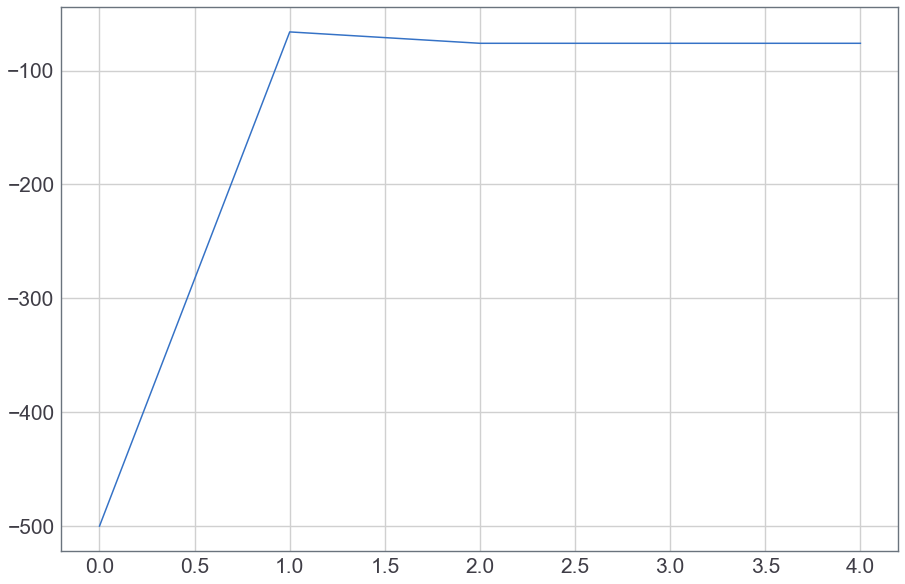

In [16]:
solver.plot_history()

In [17]:
set_params(model, solver.solution())

# Sample Model

In [21]:
run_env(env, lambda x: get_action(model, x, probabilistic=True), 5, render=True)

(-475.0, 0)